**분석 레포트 통합 분석 및 주가 예측 그리고 시각화**

Scenario

Notebook 활용한 비정형의 정형화부터 ML에 의해 생성된 정형데이터의 통합 그리고 시각화까지의 단일 파이프라인  

In [ ]:
#imports
import os
import base64
import vertexai
import vertexai.preview.generative_models as generative_models
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import seaborn as sns
from vertexai.generative_models import GenerativeModel, Part, SafetySetting, FinishReason
from google.cloud import bigquery
from google.cloud import storage
from google.api_core.exceptions import NotFound

# 환경변수 설정
project_id = "프로젝트아이디"
dataset_name = "데이터세트이름"
location = "리전"
bucket_name = "버킷명"
folder_name_in_bucket = "버킷 내 폴더명" # pdf 파일이 들은 폴더명
table = "프로젝트아이디.데이터세트이름.테이블이름" # pdf 파일이 정형화되어 저장될 테이블이며 이처럼 형식을 따라야 합니다.
genai_model = "사용모델" # 예시. "gemini-2.5-pro", "gemini-2.5-flash" # 2.5-pro 한국 리전 지원x

In [ ]:
############################################
############ 테이블 삭제 및 재생성 #############
############################################

# 빅쿼리 클라이언트 구성
client = bigquery.Client()

# 테이블 존재유무 확인 후 존재한다면 삭제 후 생성
try:
   client.get_table(table)
   print(f"테이블 {table}을 발견했습니다. 삭제를 진행합니다.")

   client.delete_table(table)
   print(f"테이블 {table}을 성공적으로 삭제했습니다.")

except NotFound:
   print(f"테이블 {table}이 존재하지않습니다. 삭제과정이 필요하지 않습니다.")

except Exception as e:
   print(f"에러 발생: {e}")

# 테이블 스키마 정의
schema = [
    bigquery.SchemaField("Company", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Industry", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Analyst_Name", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Analyst_Company", "STRING", mode="NULLABLE"),
    # 투자의견에 긍정, 부정, 중립
    bigquery.SchemaField("Investment_Score", "STRING", mode="NULLABLE"),
    # 평가 근거
    bigquery.SchemaField("Investment_Reason", "STRING", mode="NULLABLE"),
    # 총평
    bigquery.SchemaField("Comments_Summary", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("source_pdf_uri", "STRING", mode="NULLABLE"),
]

new_table = bigquery.Table(table, schema=schema)
new_table = client.create_table(new_table) # 재구성한 테이블 생성
print(f"테이블 {new_table}이 생성되었습니다.")


##################################################################
################# 버킷으로부터 PDF URI들 리스트 획득 ##################
##################################################################

def list_pdf_uris(bucket_name):
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name, prefix=folder_name_in_bucket)

    pdf_uris = []
    for blob in blobs:
        if blob.name.lower().endswith(('.pdf')):  #pdf 확장자 확인
            pdf_uris.append(f"gs://{bucket_name}/{blob.name}")
    #print(pdf_uris)
    return pdf_uris


#####################################################################
######### PDF로부터 추출한 정보 JSON으로 정리로 BQ에 로드 준비완료. #########
#####################################################################

def generate(pdf_uri):
   vertexai.init(project=project_id, location=location)
   model = GenerativeModel(genai_model)

   print(f"처리 중인 PDF : {pdf_uri}")
   pdf_part = Part.from_uri(
      uri=pdf_uri,
      mime_type="application/pdf" #MIME 타입으로 pdf 지정
   )

   responses = model.generate_content(
      [pdf_part, prompt],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True
   )

   all_text_chunks = []

   for response in responses:
      all_text_chunks.append(response.text)
      combined_text= ''.join(all_text_chunks)


   try:
      if combined_text.startswith("```json") and combined_text.endswith("```"):
         combined_text=combined_text[7:-3]
         print(f"테이블 구성위해 결합한 데이터 : \n {combined_text}")

      data= json.loads(combined_text) #json형식으로 변환

      if isinstance(data, list):
         for item in data:
            if isinstance(item, dict):
               item["source_pdf_uri"] = pdf_uri
            else:
               print(f"리스트 내 아이템이 존재하지 않습니다. {item}")
         return data
      elif isinstance(data, dict):
         print("주의: LLM이 단일 딕셔너리만 반환했고 리스트 형식이 아닙니다.")
         data["source_pdf_uri"] = pdf_uri
         data = [data] # 빅쿼리에 지속적인 로드 위해 리스트화
         return data
      else:
         print(f"ERROR: JSON로부터 리스트 또는 딕셔너리 값을 받지 못했습니다. {type(data)}")
         return None

   except json.JSONDecodeError as e:
      print(f"JSON 디코딩 에러: {e}")
      print(f"현재 결합된 텍스트상태: {combined_text}")
      return None

##################################################################
################### 빅쿼리에 JSON 데이터 로드  #######################
##################################################################

def load_to_bigquery(data, table):

  try:
    client = bigquery.Client()
    table_id = table
    job_config = bigquery.LoadJobConfig(
      schema = [
        bigquery.SchemaField("Company", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Industry", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Analyst_Name", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Analyst_Company", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Investment_Score", "STRING", mode="NULLABLE"), # 투자의견에 긍정, 중립, 부정
        bigquery.SchemaField("Investment_Reason", "STRING", mode="NULLABLE"), # 평가 근거
        bigquery.SchemaField("Comments_Summary", "STRING", mode="NULLABLE"), #총평
        bigquery.SchemaField("source_pdf_uri", "STRING", mode="NULLABLE"),
      ],

      source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
      write_disposition="WRITE_APPEND",
      # write 작업 재시도시 중복성 특성상 문제가 생기므로 테이블 삭제 과정 후 재구성이 필요
      # 즉, 해당 작업 오류시 처음 작업부터 다시 진행 필요
      )
    #빅쿼리에 데이터 로드
    job = client.load_table_from_json(data, table_id, job_config=job_config)
    job.result()  # job이 완성되도록 대기

  except Exception as e:
    print(f"빅쿼리로 데이터 로드 중 에러 발생: {e}")


##################################################################
#################### LLM 셋업 및 프롬프트 ###########################
##################################################################


prompt = """첨부된 PDF 분석해줘 해당 PDF에서 각 분석가들이 지표를 보고 분석한(표, 그래프형태일 거야. 예를들면, 실적 테이블, 영업실적, 투자지표, 실적 추정치, 재무상태표, 현금흐름표, 포괄손익계산서와 같은 것들이 있겠지.) 수치를 근거가 뒷받침 되어야 해.

1.  **Company:** 문서에서 분석의 대상이 되는 회사 이름이며 공백없이 적어야 해.
2.  **Industry:** 회사명 산업군과 사업내용을 웹에서 검색한 다음 찾은 산업명을 근거로 아래 리스트 [Industry_List]내에서만 정확히 1개만 지정하여 채워줘. 그리고, 계열사의 관계나 특정 산업에 대한 솔루션 제공여부와 상관없이 해당 회사가 직접적으로 수행하는 '핵심사업'의 산업군으로 결정해줘. 예를 들어서, 자동차계열사여서 자동차관련소프트웨어 솔루션을 제공하면 자동차업이 아니라 전산업이라는 결론이 나와. 만약 주어진 리스트에 완전히 일치하는 산업명이 없다면 가장 유사성이 높은 것으로 1개만 선택해줘. 절대 여러개 선택하지마.
     - **[Industry_List]** : [전산업, 농림어업, 광업, 제조업, 전기가스수도, 폐수처리 및 자원재활용, 건설, 제조업, 고위기술산업군, 의약, 반도체, 디스플레이, 컴퓨터, 통신기기, 가전, 정밀기기, 전지, 항공, 중고위기술산업군, 석유화학, 정밀화학, 기타 전자부품, 전기기기, 일반목적기계, 특수목적기계, 자동차, 철도, 기타 수송장비, 중저위기술산업군, 석유정제, 고무, 플라스틱, 유리, 세라믹, 시멘트, 기타 비금속 광물, 철강, 비철금속, 주조, 조립금속, 조선, 저위기술산업군, 음식료, 담배, 섬유, 의류, 가죽·신발, 목재, 제지, 인쇄, 가구, 기타 제조업, 서비스업, 유통서비스, 도·소매업, 운수·보관, 생산자서비스, 출판, 방송, 통신, 정보, 금융·보험, 부동산, 임대, 전문·과학기술, 사업시설관리서비스, 사업지원, 사회서비스, 공공교육, 교육, 의료·보건, 사회복지, 개인서비스, 숙박·음식점, 예술·스포츠·여가, 기타 서비스]
3.  **Analyst Name:** 분석가의 이름이야. 문서를 작성한 사람이기도 해. 만약 이름이 불분명하다면 "익명의 분석가"로 나타내줘.
4.  **Analyst Company:** 분석가의 회사이름이고 공백없이 적고 영어는 대문자로 채워줘. 만약 회사가 불분명하다면 "익명 회사"로 나타내줘.
     - 예를 들어서 창섭증권 리서치센터 이렇게 정리되는 경우 창섭증권으로 정리해줘. 회사명은 정확하게 회사명만 들어가야해.
5.  **Investment_Score:** 분석가의 분석내용과 근거를 전반적으로 살펴보고 분석가가 투자에 대한 생각이 어떤지 "긍정", "중립", "부정" 중 하나로만 정리해줘. 보통, 문서 내에도 Buy(유지), 중립(하향) 식으로 되어있다면 이런 지표와 매치어야 해.
     - 분류할 때 분명한 근거를 바탕으로 신중을 기하고, 아주 약간의 부정성이나 긍정성이라도 있다면 부정 또는 긍정으로 분류하세요.
     - 목표주가는 증권사 애널리스트들이 특정 주식이 향후 6개월에서 1년 이내에 도달할 것으로 예상하는 주가를 의미합니다. 이는 기업의 재무 상태, 산업 동향, 시장 상황 등을 분석하여 산출한다고하는데 목표주가가 근거될 수 있을 것 같아.
6.  **Investment_Reason:** 분석가가 5번에서 '긍정', '부정', '중립'을 판단한 근거를 적는 곳이야. 분석가는 수치적인 데이터를 근거했을 것이고 이를 바탕으로 3문장 이내로 요약해줘. 예시) A사의 6개월 간 영업이익을 보면 3%씩 우상향했으며 A사의 큰 세미나가 열린 8월에는 5%가 성장한 이익을 만들어냈습니다. 또한, 해당 산업군인 반도체 산업군은 향후 긍정적일 것으로 예상되기 때문입니다.
     - 만약 분석가가 '반도체 산업군의 미래가 밝아서 긍정적이기도 하다.' 라는 식으로 문서 데이터로 근거를 확인하기 어려운 내용은 검색해서 뉴스 기사같이 신뢰성 있는 미디어 자료만 참고하여 근거를 적어도 돼 다만, 이때는 **제미나이가 추가로 찾은 근거**라는 표시가 들어간 뒤에 문장을 추가해줘.
7.  **Comments_Summary** 해당 기업은 어떻게 전망되고 있는지 총평을 한 문장으로 요약해줘.




**출력 형식:**
결과는 JSON 리스트 형태로만 반환하세요. JSON 리스트 앞뒤에 어떤 텍스트도 포함하지 마세요. JSON은 다음 구조를 정확히 따라야 합니다:

```json
[
  {
    "Company": "회사명",
    "Industry": "산업군",
    "Analyst_Name": "성함",
    "Analyst_Company": "분석가의 회사명",
    "Investment_Score": "긍정",
    "Investment_Reason": "근거 예시 문장",
    "Comments_Summary": "요약"
  },
  {
    "Company": "구글코리아",
    "Industry": "전산업",
    "Analyst_Name": "신창섭",
    "Analyst_Company": "창섭투자증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "구글의 지난 3년 간의 영업순이익을 살펴보면 약 5%가 성장한 것을 볼 수 있습니다. 중간의 2% 하락한 시기가 있지만 경쟁사의 신제품 출시로 인한 하락으로 보여지며 대응할 수 있는 구글의 솔루션 제시로 빠르게 회복했다는 것이 그 시점에서 3개월 간의 지표가 근거됩니다. 또한, AI시대에 따라 최근 Gemini 2.5 벤치마킹의 우수성이 입증되어 회사의 성장이 지속될 것으로 보입니다.",
    "Comments_Summary": "최근 한국에서 개최한 구글클라우드데이의 성공적인 개최 및 Gemini 2.5의 성공은 AI시대에서 구글의 성장은 긍정적일 수 밖에 없습니다."
  },
  {
    "Company": "햄버거사랑",
    "Industry": "숙박·음식점"
    "Analyst Name": "김치킨",
    "Analyst Company": "치킨투자증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "햄버거사랑의 최근 피자좋아해요밴드와 콜라보레이션한 제품이 성공적으로 출시되어 판매량이 급증했습니다. 기존의 인지도가 낮던 상황을 글로벌 인지도를 가진 밴드와 협업하면서 글로벌 팬들에게도 이름을 알린 것이 크며 실제로 지난 3분기 간의 영업이익이 꾸준히 오르고 있었기 때문입니다. 대표의 사생활이 대중들에게 브랜드가 조금 부정적인 이미지를 가질 수 있도록 하는 요소긴 하지만 맛과 마케팅의 우수성으로 아직은 성장가능성이 더 긍정적입니다.",
    "Comments_Summary": "피자좋아해요밴드와 콜라보레이션한 제품과 일정금액 구매 이상시 제공하는 굿즈의 인기가 가히 폭발적이고 영업실적이 전달과 비교했을때 10% 향상되었으며 젊은 10-10대를 타겟한 다양한 팝업스토어와 같은 이벤트 성 행사가 성공적으로 이뤄지고 있습니다."
  }
]"""

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}

safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

####################### 실행 ##########################

pdf_uris = list_pdf_uris(bucket_name)

# 모든 pdf 파일 반복작업:
for pdf_uri in pdf_uris:
  data = generate(pdf_uri)
  if data:  # 데이터가 성공적으로 생성되었는지 확인 후 BQ에 로드
    load_to_bigquery(data, table)

테이블 pdf-bq-demo.changseop_test.changseop_data_test을 발견했습니다. 삭제를 진행합니다.
테이블 pdf-bq-demo.changseop_test.changseop_data_test을 성공적으로 삭제했습니다.
테이블 pdf-bq-demo.changseop_test.changseop_data_test이 생성되었습니다.
처리 중인 PDF : gs://changseop-demo-pdftobq/demo_file/1b633e15a8a91ca163b581ccaed67343.pdf


/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


테이블 구성위해 결합한 데이터 : 
 
[
  {
    "Company": "GS리테일",
    "Industry": "도·소매업",
    "Analyst_Name": "오린아",
    "Analyst_Company": "LS증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "GS리테일에 대해 투자의견 Buy를 유지하고 목표주가를 21,000원으로 상향 조정하였습니다. 이는 개발 사업 추정치 조정과 12개월 선행 실적 적용 시점 변경에 따른 것이며, 하반기 실적 기저효과와 소비쿠폰 사용에 따른 기존점 성장률 회복에 대한 기대감이 유효하기 때문입니다.",
    "Comments_Summary": "체질 개선 작업과 더불어 하반기 실적 기저효과, 그리고 민생지원금(소비쿠폰) 사용처 지정으로 인한 집객 회복을 통해 실적 개선이 기대됩니다."
  }
]

처리 중인 PDF : gs://changseop-demo-pdftobq/demo_file/58f2da7435b8c3d27179a35a764f9d29.pdf
테이블 구성위해 결합한 데이터 : 
 
[
  {
    "Company": "CJ대한통운",
    "Industry": "운수·보관",
    "Analyst_Name": "배세호",
    "Analyst_Company": "IM증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "투자의견 Buy를 유지하며 목표주가를 110,000원에서 120,000원으로 상향 조정했습니다. 이는 4Q24부터 이어진 택배 물동량 감소가 2Q25에 마무리되고 3Q25부터 다시 성장할 것이라는 전망에 근거합니다. 또한, 2026년부터는 인도와 미국 등 글로벌 자회사의 매출 성장이 본격화되며 기업 가치를 높일 것으로 기대됩니다.",
    "Comments_Summary": "CJ대한통운은 일시적인 택배 물동량 부진을 딛고 3Q25부터 성장 국면에 재진입할 것

In [ ]:
%%bigquery --project ${project_id}
#모델훈련-Model training

CREATE OR REPLACE MODEL
  `${project_id}.${dataset_name}.stock_arima_model`
OPTIONS
  (
    model_type = 'ARIMA_PLUS',
    time_series_timestamp_col = 'Date',
    time_series_data_col = 'ClosingPrice',
    time_series_id_col = 'Company',
    data_frequency = 'DAILY'
  ) AS
SELECT
  Company,
  Date,
  ClosingPrice
FROM
  `${project_id}.${dataset_name}.all_stock_data`
;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project ${project_id}
#훈련결과 -training result
SELECT
  *
FROM
  ML.EVALUATE(MODEL `${project_id}.${dataset_name}.stock_arima_model`);

Query is running:   0%|          |

Downloading:   0%|          |

,Company,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,1545,1,1,1,False,-4839.489718,9684.979437,3.479948e+04,[WEEKLY],False,True,False
1,1618,0,1,0,False,-6438.453902,12878.907804,2.814185e+06,[WEEKLY],False,True,True
2,1645,2,1,0,False,-4899.602872,9805.205743,4.104820e+04,[WEEKLY],False,False,False
3,1714,1,1,1,True,-7148.945192,14305.890384,1.981703e+07,[WEEKLY],False,True,True


In [ ]:
%%bigquery --project ${project_id}

#각 회사별 7일, 90일, 180일 뒤 예측 주가 및 테이블 생성
CREATE OR REPLACE TABLE `${project_id}.${dataset_name}.prediction_result`
AS
SELECt
  CASE Company
       WHEN 1545 THEN 'KH바텍'
       WHEN 1618 THEN 'CJ대한통운'
       WHEN 1645 THEN 'GS리테일'
       ELSE 'HD현대중공업'
  END AS Company,
  DATE(forecast_timestamp) AS Date,
  CAST(ROUND(prediction_interval_upper_bound) AS INT64) AS Prediction_interval_upper_bound,
  CAST(ROUND(forecast_value) AS INT64) AS Forecast_value,
  CAST(ROUND(prediction_interval_lower_bound) AS INT64) AS Prediction_interval_lower_bound
FROM
  ML.FORECAST(
    MODEL `${project_id}.${dataset_name}.stock_arima_model`,
    STRUCT(300 AS horizon,
           0.95 AS confidence_level
    )
  )
WHERE
  forecast_timestamp IN (
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 7 DAY) AS TIMESTAMP),
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 90 DAY) AS TIMESTAMP),
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 180 DAY) AS TIMESTAMP)
  )
ORDER BY
  1, 2

;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project ${project_id}
####투자스코어가 긍정으로 판단된 종목만의 향후 가격 예측######
################최종테이블 생성#######################
CREATE OR REPLACE TABLE `${project_id}.${dataset_name}.final_result`
AS(
WITH unpivotTable AS (
  SELECT
    Company,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 7 DAY) THEN Prediction_interval_upper_bound END) AS predict_7,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 90 DAY) THEN Prediction_interval_upper_bound END) AS predict_90,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 180 DAY) THEN Prediction_interval_upper_bound END) AS predict_180,
  FROM
    `${project_id}.${dataset_name}.prediction_result`
  GROUP BY
    Company
)

SELECT
  t1.* EXCEPT(source_pdf_uri),
  t3.ClosingPrice as CurrentPrice,
  t2.* EXCEPT(Company)
FROM
  `${table}` AS t1
JOIN
  unpivotTable AS t2
ON
  t1.Company = t2.Company
JOIN
  (SELECT
    CASE Company
      WHEN 1545 THEN 'KH바텍'
      WHEN 1618 THEN 'CJ대한통운'
      WHEN 1645 THEN 'GS리테일'
      ELSE 'HD현대중공업'
    END AS Company,
    ClosingPrice
  FROM
    `${project_id}.${dataset_name}.all_stock_data`
  WHERE
    Date = '2025-07-21'
  ) as t3
ON t1.Company = t3.Company
WHERE
  t1.Investment_Score = '긍정'
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project ${project_id}
####투자스코어가 긍정으로 판단된 종목만의 향후 가격 예측######
################최종테이블 생성#######################

WITH unpivotTable AS (
  SELECT
    Company,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 7 DAY) THEN Prediction_interval_upper_bound END) AS predict_7,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 90 DAY) THEN Prediction_interval_upper_bound END) AS predict_90,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 180 DAY) THEN Prediction_interval_upper_bound END) AS predict_180,
  FROM
    `${project_id}.${dataset_name}.prediction_result`
  GROUP BY
    Company
)

SELECT
  t1.* EXCEPT(source_pdf_uri),
  t3.ClosingPrice as CurrentPrice,
  t2.* EXCEPT(Company)
FROM
  `${table}` AS t1
JOIN
  unpivotTable AS t2
ON
  t1.Company = t2.Company
JOIN
  (SELECT
    CASE Company
      WHEN 1545 THEN 'KH바텍'
      WHEN 1618 THEN 'CJ대한통운'
      WHEN 1645 THEN 'GS리테일'
      ELSE 'HD현대중공업'
    END AS Company,
    ClosingPrice
  FROM
    `${project_id}.${dataset_name}.all_stock_data`
  WHERE
    Date = '2025-07-21'
  ) as t3
ON t1.Company = t3.Company
WHERE
  t1.Investment_Score = '긍정'
;

Query is running:   0%|          |

Downloading:   0%|          |

,Company,Industry,Analyst_Name,Analyst_Company,Investment_Score,Investment_Reason,Comments_Summary,CurrentPrice,predict_7,predict_90,predict_180
0,KH바텍,기타 전자부품,양승수,메리츠증권,긍정,2025년 2분기 예상 영업이익은 126억원(+48.1% YoY)으로 시장 컨센서스...,KH바텍은 삼성전자 신규 폴더블폰의 두께 및 무게 감소에 따른 힌지 ASP 상승과 ...,13130,17158,19286,21162
1,GS리테일,도·소매업,오린아,LS증권,긍정,"투자의견 'Buy'를 유지하고 목표주가를 21,000원으로 상향 조정하였습니다. 이...",GS리테일은 편의점과 슈퍼 사업의 부진에도 불구하고 개발 사업부의 흑자 전환과 하반...,17540,21186,23594,25337
2,CJ대한통운,운수·보관,배세호,iM증권,긍정,"목표주가를 120,000원으로 상향하며, 2024년 4분기부터 지속된 택배 물동량 ...",CJ대한통운은 2025년 3분기부터 국내 택배 물동량의 반등과 글로벌 자회사의 본격...,92200,114972,129908,141102
3,HD현대중공업,조선,한승한,SK증권,긍정,"2Q25 연결 영업이익이 전년 동기 대비 129.8% 증가한 4,496억 원으로 시...",HD현대중공업은 견조한 수주 실적과 고부가가치 선박 중심의 건조 비중 확대로 점진적...,425000,529233,598190,664015


Investment_Score
Positive    4
Negative    0
Neutral     0
Name: count, dtype: int64


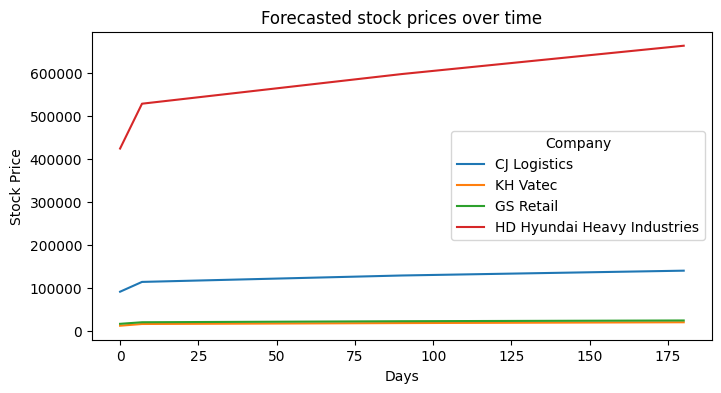

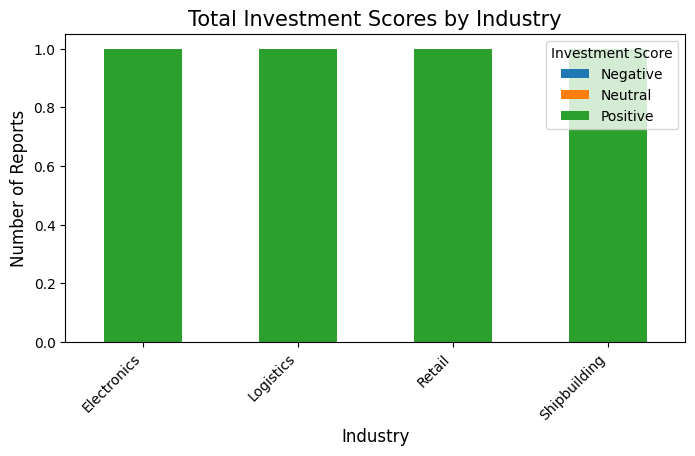

In [ ]:
full_table_path = f"{project_id}.{dataset_name}.final_result"


sentiment_order = ["Negative", "Neutral", "Positive"]
color_map = {
    "Negative": "#FF6347",  # Tomato Red
    "Neutral": "#FFD700",   # Gold Yellow
    "Positive": "#3CB371"   # MediumSeaGreen
}

try:
    client = bigquery.Client(project=project_id)

    query = f"""
        SELECT
            CASE Company
              WHEN 'KH바텍' THEN 'KH Vatec'
              WHEN 'GS리테일' THEN 'GS Retail'
              WHEN 'HD현대중공업' THEN 'HD Hyundai Heavy Industries'
              ELSE 'CJ Logistics'
            END AS Company,
            Industry,
            Analyst_Name,
            Analyst_Company,
            CASE Investment_Score
                WHEN '부정' THEN 'Negative'
                WHEN '긍정' THEN 'Positive'
                WHEN '중립' THEN 'Neutral'
                ELSE Investment_Score
            END AS Investment_Score,
            CurrentPrice,
            predict_7,
            predict_90,
            predict_180
        FROM
            `{full_table_path}`
        WHERE
            Investment_Score IN ('부정', '중립', '긍정');
    """

    df = client.query(query).to_dataframe()

    #1. 긍정, 중립, 부정 갯수
    df['Investment_Score'] = pd.Categorical(df['Investment_Score'], categories=sentiment_order, ordered=True)
    print(df['Investment_Score'].value_counts())

    #2. 회사별 주식 가격 추이 예측
    price_df = df[['Company', 'CurrentPrice', 'predict_7', 'predict_90', 'predict_180']]
    price_df = price_df.melt(id_vars='Company', var_name='Day', value_name='Price')

    price_df['Day'] = price_df['Day'].str.extract('(\d+)').fillna(0).astype(int)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=price_df, x='Day', y='Price', hue='Company')
    plt.title('Forecasted stock prices over time')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.legend(title='Company')
    plt.show()

    #3. 산업군별 긍정, 중립, 부정 지표
    df_en = df.copy()
    df_en['Industry'] = df_en['Industry'].replace({
        '기타 전자부품': 'Electronics',
        '운수·보관': 'Logistics',
        '조선': 'Shipbuilding',
        '도·소매업': 'Retail',
        '유통서비스': 'Retail'
    })

    industry_investment_en = df_en.groupby(['Industry', 'Investment_Score'], observed=False).size().unstack(fill_value=0)
    industry_investment_en.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title('Total Investment Scores by Industry', fontsize=15)
    plt.xlabel('Industry', fontsize=12)
    plt.ylabel('Number of Reports', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Investment Score')
    plt.show()

except Exception as e:
    print(f"BigQuery 쿼리 실행 또는 데이터 처리 중 오류 발생: {e}")
    print("BigQuery 프로젝트 ID, 데이터셋 ID, 테이블 이름이 올바르게 설정되었는지 확인해주세요.")

# **Review**

비정형, 정형 데이터의 통합으로 데이터 준비부터 분석, 예측, 시각화 모두를 하나의 워크플로우를 수행하여 새로운 인사이트 도출
  *   BigQuery Notebook에서 Python, SQL, 기타 패키지 및 API 활용 가능
  *   생성형 AI를 활용한 비정형데이터의 정형화
  *   내장된 BQML모델을 활용하여 ML작업(i.e. 예측) 수행

  # **Call to Action**
  *   Gitlab
  *   Contact to Changseop, Sehwee   